In [3]:
import networkx as nx
import numpy as np
import random
from math import isclose
import copy
import time

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('./Metropolis/')
sys.path.append('./src')

from metropolisHastings import MetropolisHasting, plotMetropolisHastingsResult, iterMHBeta
from markovTransforms import TReconnectOriginOfEdgeToOtherNode
from networkSigma import discreteSigma2Analytical, continuousSigma2Analytical, continuousSigma2AnalyticalHT
from measuresFunctions import getMeasuresDirected
from pickleUtil import pickleLoad, pickleSave
from networkGenerator import flattenIncomingDegree, makeColumnStochastic, getDirectedErdosRenyi, \
sumColumns, randomDegreeSequence, fixedDegreeSequence, \
getDirectedConfigurationModel, flattenIncomingDegree
from gvisu import drawMatrix
import matplotlib.pyplot as plt
import math
from gvisu import drawMatrix, plotOrderedDistanceMatrix
from pickleUtil import pickleLoad
from measuresFunctions import plotDegreeDistribution, plotInDegreeDistribution, plotOutDegreeDistribution, plotOutEdgeWeightDistribution
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram, optimal_leaf_ordering

DATAFOLDER='./data'

In [4]:
''' 
Toy models:

(1) fixed weights, degree 2 (or 3,4,5), 2 -> 2 lines, 3 --> 3 lines etc...
(2) regular network, degree 2 (or 3,4,5)
(3) random network
(4) small world network
(5) powerlaw network
(6) stochastic block model

'''
def drawMatrixAndPrintSigma(g, deg, experiment_title):
    C = nx.to_numpy_array(g)
    sumC = sumColumns(C)
    sigma2=math.inf
    N=C.shape[0]

    if (np.all(np.isclose(sumC, np.array([[1 for _ in range(N)]]), atol=1e-12))):
        sigma2 = continuousSigma2Analytical(g)
      
    print(f'{experiment_title} sigma2 continuous : ', sigma2)
    print('-------------------------------------------------------------------------------------------------------')
    
    kwargs = { 'vmin': 0, 'vmax': 1/deg, 'cmap': plt.cm.hot }
    drawMatrix(g, experiment_title=experiment_title, folder='./images', showImages=True, **kwargs)
    

def getRandom(N, deg):
    p = deg/N
    g = getDirectedErdosRenyi(N, p, max_trials=3000)
    g = makeColumnStochastic(g, with_random_weights_initialization=False)
    
    #drawMatrixAndPrintSigma(g, deg, f'Random network average degree {deg} ')
    
    return g

def getToyLines(N, deg):

    lines=[]
    for i in range(deg):
        for n in range(N):
            if n != 10*(i+1):
                lines.append((10*(i+2), n, 1/deg))
                lines.append((n,10*(i+2), 1/N))

    g = nx.DiGraph()

    g.add_weighted_edges_from(lines, weight='weight')
    g = makeColumnStochastic(g, with_random_weights_initialization=False)
    
    #drawMatrixAndPrintSigma(g, deg, f'Lines network degree {deg} ')

    return g

def getRegular(N, deg):

    g = nx.random_regular_graph(d=deg, n=N)
    g = nx.DiGraph(g)

    g = makeColumnStochastic(g, with_random_weights_initialization=False)
    
    #drawMatrixAndPrintSigma(g, deg, f'Regular network degree {deg} ')
    
    return g


# Statistical sigma

## getToyLines(N, deg) , getRegular(N, deg), getRandom(N, deg)

In [8]:
from networkSigma import discreteSigma2Analytical, continuousSigma2Analytical
import numpy as np

imax=10000

N=100
deg = 4

networkG = getRandom #getToyLines

continuousSigmas=[]
discreteSigmas=[]
for i in range(imax):
    g = networkG(N, deg)
    
    mDis = discreteSigma2Analytical(g)
    mCont = continuousSigma2Analytical(g)
    continuousSigmas.append(mCont)
    discreteSigmas.append(mDis)
    
continuousSigmas=np.array(continuousSigmas)
discreteSigmas=np.array(discreteSigmas)   

print(f'{networkG.__name__} with {N} nodes and degree {deg}:')
print(f'Continuous Sigma: {continuousSigmas.mean()} +- {continuousSigmas.std()}')
print(f'Discrete Sigma: {discreteSigmas.mean()} +- {discreteSigmas.std()}')

getRandom with 100 nodes and degree 4:
Continuous Sigma: 0.5932326231133033 +- 0.026181045300881098
Discrete Sigma: 1.851165580575217 +- 7.998756241383375


In [9]:
print(f'Discrete Sigma: {discreteSigmas.mean()} +- {discreteSigmas.std()}')

Discrete Sigma: 1.0149146547196781 +- 2.220446049250313e-16


## Random degree 3

Random network average degree 3  sigma2 continuous :  0.6365176781334136
-------------------------------------------------------------------------------------------------------


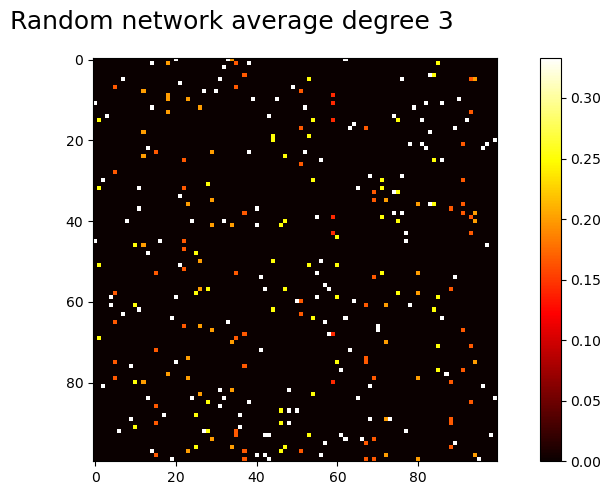

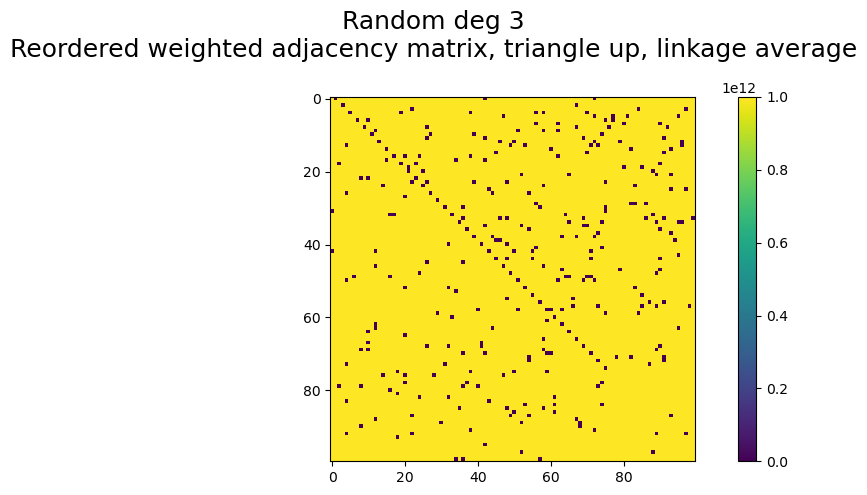

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'OutEdgeWeightDistribution'}>)

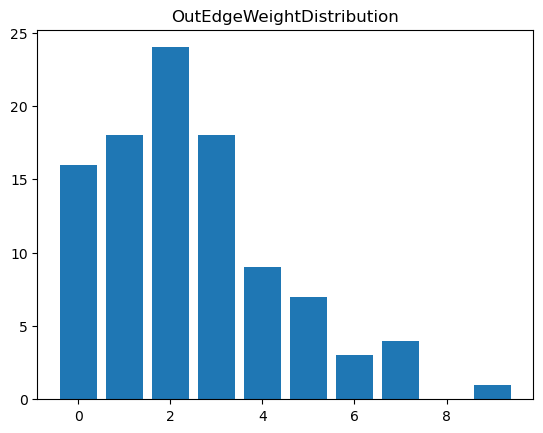

In [26]:
N=100
deg = 3
g = getRandom(N, deg)
kwargs = { 'vmin': 0, 'vmax': 1/deg, 'cmap': plt.cm.hot }
experiment_name = f'Random deg {deg}'

plotOrderedDistanceMatrix(g, triangle='up', linkage=average, zeroes=1e-12, experiment_title=experiment_name)
plotOutEdgeWeightDistribution(g, density=False)

## Regular

Regular network degree 4  sigma2 continuous :  0.7185571409867504
-------------------------------------------------------------------------------------------------------


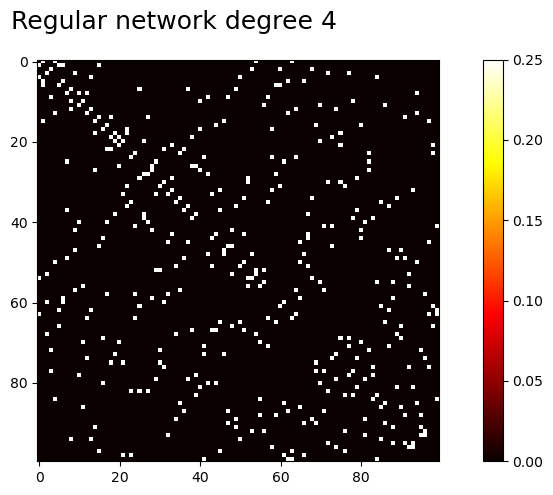

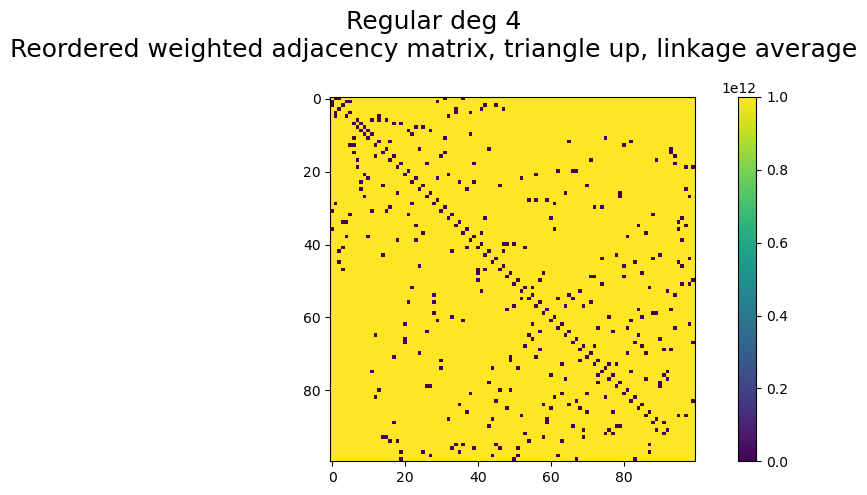

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'OutEdgeWeightDistribution'}>)

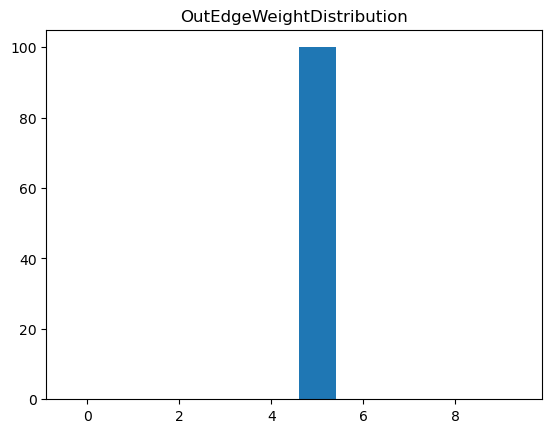

In [25]:
N=100
deg = 4
g = getRegular(N, deg)
kwargs = { 'vmin': 0, 'vmax': 1/deg, 'cmap': plt.cm.hot }
experiment_name = f'Regular deg {deg}'

plotOrderedDistanceMatrix(g, triangle='up', linkage=average, zeroes=1e-12, experiment_title=experiment_name)
plotOutEdgeWeightDistribution(g, density=False)

## Toy Lines deg 2

Lines network degree 2  sigma2 continuous :  0.49303526448799273
-------------------------------------------------------------------------------------------------------


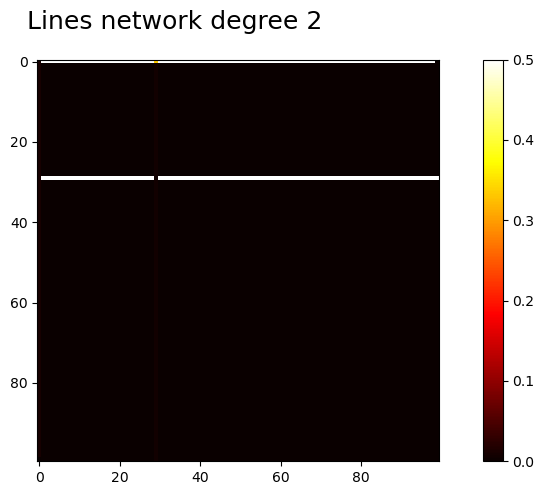

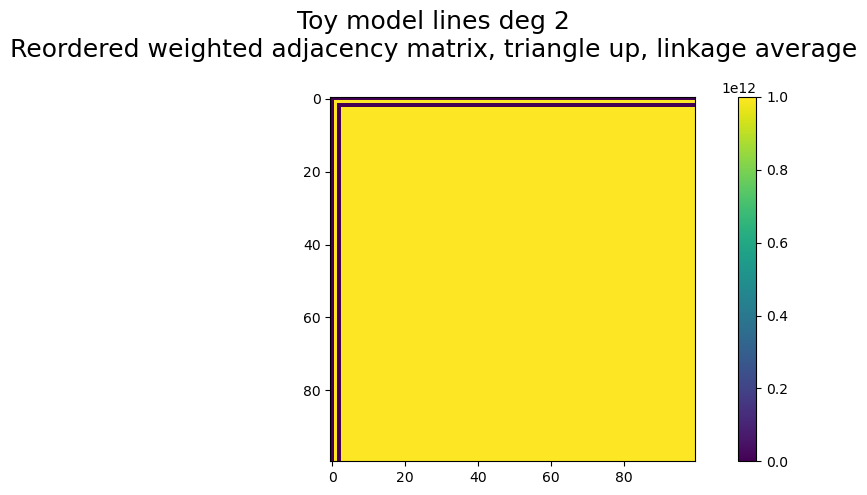

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'OutEdgeWeightDistribution'}>)

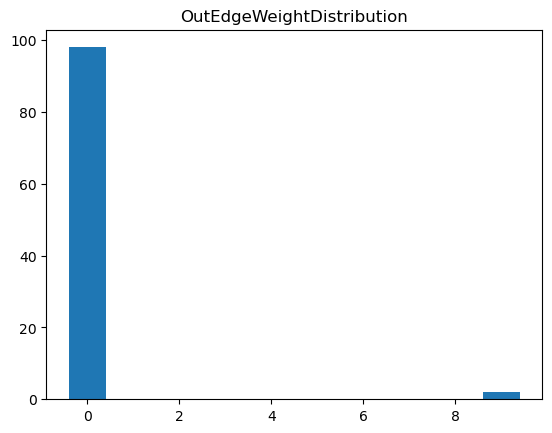

In [24]:
N=100
deg = 2
g = getToyLines(N, deg)
kwargs = { 'vmin': 0, 'vmax': 1/deg, 'cmap': plt.cm.hot }
experiment_name = f'Toy model lines deg {deg}'

plotOrderedDistanceMatrix(g, triangle='up', linkage=average, zeroes=1e-12, experiment_title=experiment_name)
plotOutEdgeWeightDistribution(g, density=False)

## Toy Line deg = 3

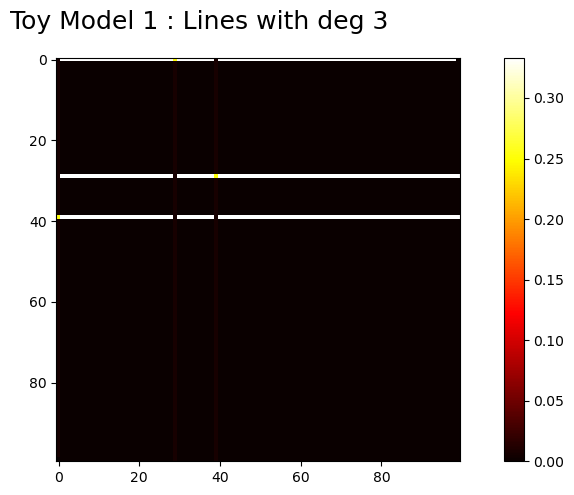

Toy model line with in-degree 3 sigma2 continuous :  0.492149288005387


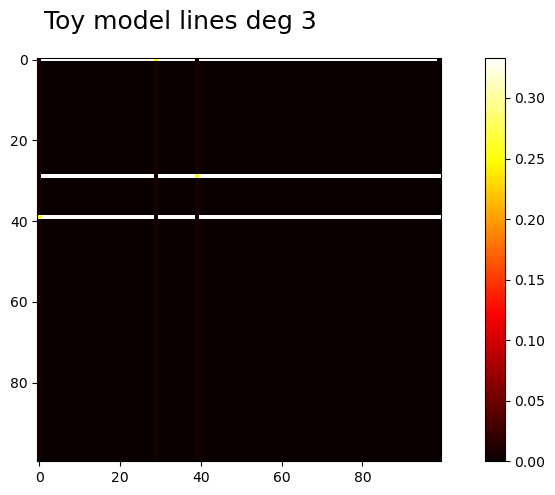

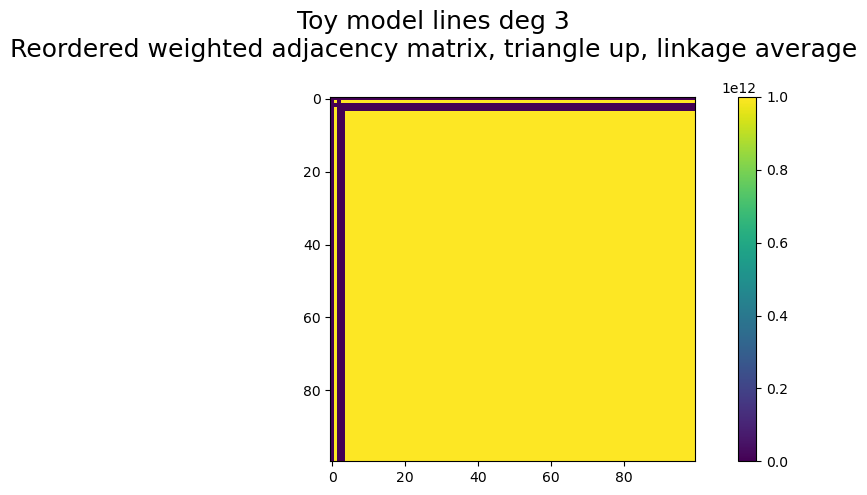

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'OutEdgeWeightDistribution'}>)

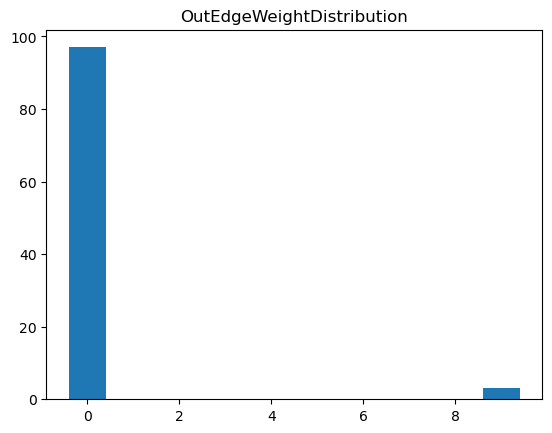

In [3]:
N=100
deg = 3
g = getToyLines(N, deg)
kwargs = { 'vmin': 0, 'vmax': 1/deg, 'cmap': plt.cm.hot }
experiment_name = f'Toy model lines deg {deg}'
#drawMatrix(g, experiment_title=experiment_name, folder='./images', showImages=True, **kwargs)
plotOrderedDistanceMatrix(g, triangle='up', linkage=average, zeroes=1e-12, experiment_title=experiment_name)
plotOutEdgeWeightDistribution(g, density=False)

## Toy Line deg 4

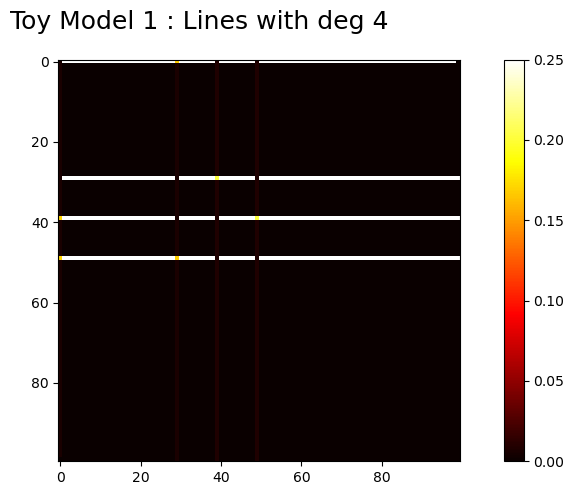

Toy model line with in-degree 4 sigma2 continuous :  0.49192073811807435


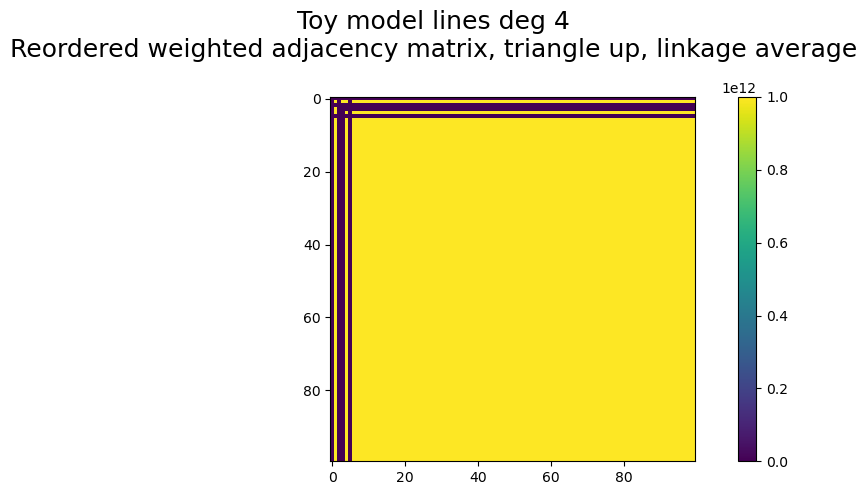

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'OutEdgeWeightDistribution'}>)

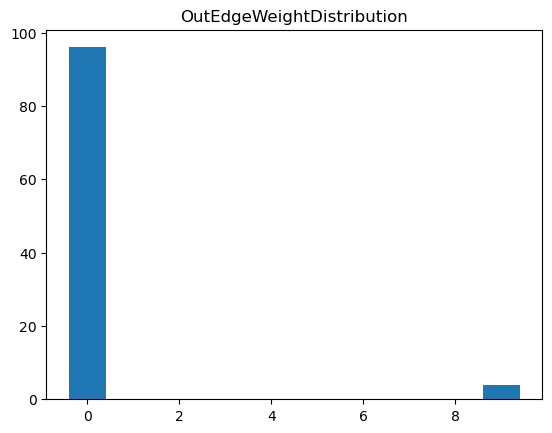

In [5]:
N=100
deg = 4
g = getToyLines(N, deg)
kwargs = { 'vmin': 0, 'vmax': 1/deg, 'cmap': plt.cm.hot }
experiment_name = f'Toy model lines deg {deg}'

plotOrderedDistanceMatrix(g, triangle='up', linkage=average, zeroes=1e-12, experiment_title=experiment_name)
plotOutEdgeWeightDistribution(g, density=False)